In [3]:
import sys
sys.path.append('../..')
sys.path.append('../../lib/src/')
import torch
import numpy as np
from torch import nn
import os
from matplotlib import pyplot as plt
import lightning as L
from sklearn.decomposition import PCA

from lib.src.pythae.models import VAE
from lib.scripts.utils import Encoder_Chairs,Decoder_Chairs, My_Dataset, My_MaskedDataset, make_batched_masks
from lib.src.pythae.models.vae import VAEConfig
from lib.src.pythae.trainers import BaseTrainerConfig
from lib.src.pythae.pipelines.training import TrainingPipeline
from lib.src.pythae.samplers.normal_sampling import NormalSampler
from lib.src.pythae.samplers.manifold_sampler import RHVAESampler

sys.path.append('diffusion/stable_diffusion/')
sys.path.append('diffusion/stable_diffusion/model/')
from diffusion.stable_diffusion.latent_diffusion import LatentDiffusion, DiffusionWrapper, MyLatentDiffusion, LitLDM
from diffusion.stable_diffusion.model.autoencoder import Autoencoder
from diffusion.stable_diffusion.model.clip_embedder import CLIPTextEmbedder
from diffusion.stable_diffusion.model.unet import UNetModel, _test_time_embeddings
from diffusion.stable_diffusion.sampler.ddim import DDIMSampler

%reload_ext autoreload
%autoreload 2

In [5]:
#device = 'cuda' if torch.cuda.is_available() else 'cpu'
PATH_DATA = 'data-models/sprites/data/data/Sprites_train.pt'
PATH_DATA_TEST = 'data-models/sprites/data/data/Sprites_test.pt'
device = 'cpu'
train_data = torch.load(PATH_DATA)[:-1000, -2, :, :, :].to(device) #only keeping the last frame of each sequence
eval_data = torch.load(PATH_DATA_TEST), map_location="cpu")[-1000:, -2, :, :, :].to(device)
#test_data = torch.load(os.path.join('lib/my_data/sprites/Sprites_test.pt'), map_location="cpu")[:, -1, :, :, :].to(device)
print(train_data.shape)
train_data = train_data.permute(0, 3, 1, 2)
eval_data = eval_data.permute(0, 3, 1, 2)
#test_data = test_data.permute(0, 3, 1, 2)
print(train_data.shape)

train_seq_mask = torch.ones(train_data.shape[:2], requires_grad=False).type(torch.bool).to(device)
eval_seq_mask = torch.ones(eval_data.shape[:2], requires_grad=False).type(torch.bool).to(device)
#test_seq_mask = torch.ones(test_data.shape[:2], requires_grad=False).type(torch.bool).to(device)
train_pix_mask = torch.ones_like(train_data, requires_grad=False).type(torch.bool).to(device)
eval_pix_mask = torch.ones_like(eval_data, requires_grad=False).type(torch.bool).to(device)
#test_pix_mask = torch.ones_like(test_data, requires_grad=False).type(torch.bool).to(device)

train_dataset = My_MaskedDataset(train_data, train_seq_mask, train_pix_mask)
eval_dataset = My_MaskedDataset(eval_data, eval_seq_mask, eval_pix_mask)
#test_dataset = My_MaskedDataset(test_data, test_seq_mask, test_pix_mask)

torch.Size([8000, 64, 64, 3])
torch.Size([8000, 3, 64, 64])


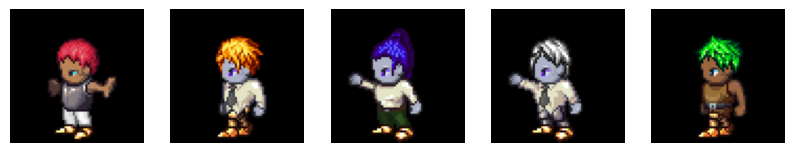

In [6]:
#check
plt.figure(figsize=(10, 10))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(train_dataset[i][0].data.cpu().permute(1, 2, 0))
    plt.axis('off')
plt.show()

In [7]:
input_dim = (3, 64, 64)
f = 32 #subsampling factor
latent_dim = 3* (64 // f) * (64 // f)
print('Latent dim:', latent_dim)

device = 'cuda'
vae = VAE.load_from_folder('data-models/sprites/trained_models/pre_trained_vae/final_model').to(device)
vae.eval()


Latent dim: 12


VAE(
  (decoder): Decoder_Chairs(
    (fc): Linear(in_features=12, out_features=2048, bias=True)
    (layers): Sequential(
      (0): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ResBlock(
        (conv_block): Sequential(
          (0): ReLU()
          (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): ReLU()
          (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
        )
      )
      (2): ResBlock(
        (conv_block): Sequential(
          (0): ReLU()
          (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): ReLU()
          (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
        )
      )
      (3): ResBlock(
        (conv_block): Sequential(
          (0): ReLU()
          (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): ReLU()
          (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
        )
  

In [8]:

def load_config_unet(config):
    return UNetModel(
        in_channels=config['in_channels'],
        out_channels=config['out_channels'],
        channels=config['channels'],
        n_res_blocks=config['n_res_blocks'],
        attention_levels=config['attention_levels'],
        channel_multipliers=config['channel_multipliers'],
        n_heads=config['n_heads'],
    )


######## UNET #######
# in_channels = 3
# out_channels = 3
# channels = 64
# n_res_blocks = 2
# attention_levels = [3]
# channel_multipliers = (1, 2, 2, 4)
# n_heads = 2

in_channels = 3
out_channels = 3
channels = 64
n_res_blocks = 4
attention_levels = [0]
channel_multipliers = [1]
n_heads = 4

unet_config = {
    'in_channels': in_channels,
    'out_channels': out_channels,
    'channels': channels,
    'n_res_blocks': n_res_blocks,
    'attention_levels': attention_levels,
    'channel_multipliers': channel_multipliers,
    'n_heads': n_heads,
}

unet = load_config_unet(unet_config)

h, w = 64//f, 64//f


z = torch.randn(1, 3, h, w)
print("Shape of input U-NET: ", z.shape)
empty_prompt_embed = None
print("Shape of output: ", unet(z, torch.tensor([10]), empty_prompt_embed).shape)
print("Number of trainable params: ", sum(p.numel() for p in unet.parameters() if p.requires_grad))

latent_scaling_factor = 1
n_steps = 1000
linear_start =  0.00085
linear_end = 0.0012


latent_diffusion = MyLatentDiffusion(unet, None, latent_scaling_factor, n_steps, linear_start, linear_end)
# print("Number of trainable params (should not change): ", sum(p.numel() for p in latent_diffusion.parameters() if p.requires_grad))
# model = LitLDM.load_from_checkpoint('ldm/lightning_logs/version_12/checkpoints/epoch=49-step=1600.ckpt', ldm = latent_diffusion, vae = vae, latent_dim = latent_dim).to('cuda')

# BATCH_SIZE = 256

# train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, num_workers = 12)
# val_loader = torch.utils.data.DataLoader(eval_data, batch_size=800, num_workers = 12)

# print()
# print('Should be equal to linear end...')
# print(model.ldm.beta[-1].item())

Shape of input U-NET:  torch.Size([1, 3, 2, 2])
Shape of output:  torch.Size([1, 3, 2, 2])
Number of trainable params:  2223043


In [17]:
import torchinfo
print(torchinfo.summary(unet, input_size=(1, 3, h, w), cond = None, time_steps = torch.tensor([10])))
print(torchinfo.summary(vae))

Layer (type:depth-idx)                                       Output Shape              Param #
UNetModel                                                    [1, 3, 2, 2]              --
├─Sequential: 1-1                                            [1, 256]                  --
│    └─Linear: 2-1                                           [1, 256]                  16,640
│    └─SiLU: 2-2                                             [1, 256]                  --
│    └─Linear: 2-3                                           [1, 256]                  65,792
├─ModuleList: 1-2                                            --                        --
│    └─TimestepEmbedSequential: 2-4                          [1, 64, 2, 2]             --
│    │    └─Conv2d: 3-1                                      [1, 64, 2, 2]             1,792
│    └─TimestepEmbedSequential: 2-5                          [1, 64, 2, 2]             --
│    │    └─ResBlock: 3-2                                    [1, 64, 2, 2]          

In [ ]:
n_steps = 1000
linear_start =  0.00085
linear_end = 0.012
latent_scaling_factor = 1
lr = 5*1e-6
BATCH_SIZE = 256
MAX_EPOCHS = 50

# vae = vae.to('cuda')
# latent_diffusion = MyLatentDiffusion(unet, None, latent_scaling_factor, n_steps, linear_start, linear_end)
# model = LitLDM(ldm = latent_diffusion, vae = vae, lr = lr).to('cuda')



train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, num_workers = 12)
val_loader = torch.utils.data.DataLoader(eval_data, batch_size=800, num_workers = 12)

trainer = L.Trainer(max_epochs=MAX_EPOCHS,
                     default_root_dir='ldm', accelerator = 'gpu', 
                     check_val_every_n_epoch=5)



trainer.fit(model, train_loader, val_loader)

#model = LitLDM.load_from_checkpoint('ldm/lightning_logs/version_3/checkpoints/epoch=149-step=4800.ckpt', ldm = latent_diffusion, vae = vae, latent_dim = latent_dim).to('cuda')

In [38]:
vae = vae.to('cuda')
model = model.to('cuda')
trainer = L.Trainer()
trainer.validate(model, val_loader)
trainer.validate(model, train_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │    4.5796966552734375     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │     4.588048934936523     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 4.588048934936523}]